# PeakDetective Usage Examples and Tutorial

This notebook details different use cases for the PeakDetective software applied to the processing of LC/MS metabolomics data.

If you have any questions or encounter any issues, please contact Ethan at gjpcolab@gmail.com. 

Files can be downloaded from the panel to the left. For faster performance, connect to a GPU by changing the runtime.



Before you start: upload files using the panel to the left or run the cell below to download example data

In [1]:
import os
os.system("git clone https://github.com/pattilab/example_data_for_colab.git")

128

# Install PeakDetective

In [9]:
#!pip install PeakDetective
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import pickle as pkl
import os
import shutil

#model parameters, not recomended to change
resolution = 60 #number of data point in 1 min EIC
window = 1.0 #size of EIC window (in minutes)
min_peaks = 100000 #minimum number of peaks used to train autoencoder
smooth_epochs = 10 #number of smoothing epochs to use
batchSizeSmoother = 64 #batch size for training smoother
validationSplitSmoother = 0.1 #fraction of data used for validation split when training smoother
minClassifierTrainEpochs = 200 #minimum number of epochs for training classifier
maxClassifierTrainEpochs = 1000 #maximum number of epochs for training classifier
classifierBatchSize = 4 #batch size for training classifier
randomRestarts = 1 #number of random restarts to use when training classifier
numValPeaks = 10 #number of validaiton peaks for user to label
numPeaksPerRound = 10 #number of peaks to label per active learning iteration
numCores = 20 #number of processor cores to use
numDataPoints = 3 #number of consequetive scans above noise to count as ROI

If you want to run mz.unity to remove degeneracies or run XCMS: the relevant R packages must also be installed (>20 min)

In [2]:
detection_helper.PeakList().installRPackages()

# Training/loading the PeakDetective models

Before the workflows detailed in this notebook can be run, the nueral networks that underpin PeakDetective must be trained or the trained weights must be loaded

## Training

Step 1: load raw data and peak list

What filename is your uploaded file or what we should name your generated peak list? If you need to generate a peak list, see Step 3 of the curating peak list section below for running XCMS

In [2]:
peakFile = "example_data_for_colab/xcms_example_data/peaks.csv" #path to peak file

Step 2: Where is your data?

In [3]:
mzmlFolder = "example_data_for_colab/xcms_example_data/" #path to raw data folder

Step 3: Set data parameters: 

In [4]:
ms1ppm = 25.5 #ppm tolerance
align = True  #whether to perform RT alignment or not (True=align, False=do not align)

Step 4: Load data:

In [5]:
#load peak list
peaklist = pd.read_csv(peakFile)[["mz","rt"]]

#load raw data
raw_data = []
for file in [x for x in os.listdir(mzmlFolder) if ".mzML" in x]:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(mzmlFolder + "/" + file,ms1ppm)
    raw_data.append(temp)

Step 5: Initialize PeakDetective object

In [6]:
integ = PeakDetective.PeakDetective(numCores = numCores,resolution=resolution)

Step 6: Generate EICs

In [7]:
if __name__ == "__main__":
    X = integ.makeDataMatrix(raw_data,peaklist["mz"],peaklist["rt"].values,align=align)

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


Step 7: Train smoother

In [16]:
if __name__ == "__main__":
    integ.trainSmoother(peaklist,raw_data,min_peaks,smooth_epochs,batchSizeSmoother,validationSplitSmoother)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 31s 21ms/step - loss: 0.1329 - mean_absolute_error: 0.0577 - val_loss: 0.0817 - val_mean_absolute_error: 0.0157
Epoch 2/10
1407/1407 [==============================] - 30s 21ms/step - loss: 0.0787 - mean_absolute_error: 0.0142 - val_loss: 0.0757 - val_mean_absolute_error: 0.0121
Epoch 3/10
1407/1407 [==============================] - 31s 22ms/step - loss: 0.0741 - mean_absolute_error: 0.0109 - val_loss: 0.0733 - val_mean_absolute_error: 0.0104
Epoch 4/10
1407/1407 [==============================] - 31s 22ms/step - loss: 0.0727 - mean_absolute_error: 0.0100 - val_loss: 0.0725 - val_mean_absolute_error: 0.0098
Epoch 5/10
1407/1407 [==============================] - 31s 22ms/step - loss: 0.0721 - mean_absolute_error: 0.0096 - val_loss: 0.0721 - val_mean_absolute_error: 0.0095
Epoch 6/10
1407/1407 [==================

Step 8: Train classifier. First you will be prompted to label peaks that will be used as the validation data to see how the model performs. Afterwards, each active learning iteration will prompt additional peaks to be labeled. These are used to train the model. After each iteration a histogram of the scores for all peaks will be plotted and the accuacy of the model on training and validation data will be reported. After 5-10 iterations, a bimodal distribution of scores will be produced and the val_mean_absolute_error will drop dramatically. At this point, the model is trained and the FDR and TPR estimates based on the validation data will be reported for each cutoff. Inspection on this plot is used to set the threshold to use when applying the model.

1/1 [==============================] - 0s 29ms/step
loss: 0.546790361404419 mean_absolute_error: 0.3347395360469818 val loss: 0.47465428709983826 val_mean_absolute_error: 0.2328321933746338 numEpochs: 412
478/478 [==============================] - 1s 1ms/step


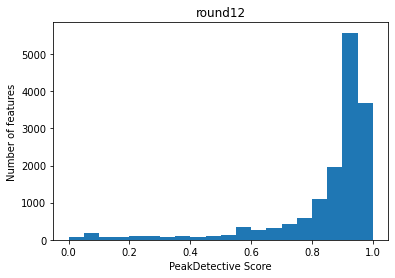

15278 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


1/1 [==============================] - 0s 21ms/step


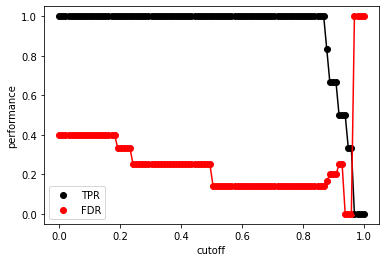

In [19]:
if __name__ == "__main__":
    #train classifier
    integ.trainClassifierActive(X,[],[],minClassifierTrainEpochs,maxClassifierTrainEpochs,classifierBatchSize,randomRestarts,numVal = numValPeaks,numManualPerRound=numPeaksPerRound,inJupyter=True)

Based on the TPR and FDR curves plotted above, set the cutoff based on your own preferences for specificity and sensitivity. 

Set the cutoff

In [22]:
cutoff = 0.8

Step 9: save the model

In [23]:
integ.save(mzmlFolder+"PeakDetectiveObject/")

## Loading trained model

Step 1: set path to PeakDetective weights

In [10]:
weightsPath = "example_data_for_colab/xcms_example_data/PeakDetectiveObject/"

Step 2: intitalize PeakDetective object and load weights

In [11]:
integ = PeakDetective.PeakDetective(numCores = numCores,resolution=resolution)
integ.load(weightsPath)

Set the cutoff

In [12]:
cutoff = 0.8

# Curating a peak list:

Step 1: Upload or generate a peak list

What filename is your uploaded file or what we should name your generated peak list?

In [6]:
peakFile = "example_data_for_colab/xcms_example_data/peaks.csv" #path to peak file

Step 2: Where is your data?

In [7]:
mzmlFolder = "example_data_for_colab/xcms_example_data/" #path to raw data folder

Step 3: Run XCMS to generate peak list (skip if you have already done this)

What parameters do you want to use?

In [13]:
ms1ppm = 25.5 #ppm tolerance
peakWidth = (13.8,114.6) #retentin time peak width range (in seconds)
s2n = 13.6 #signal to noise cutoff
noise = 1 #noise threshold
mzDiff = 0.0144 #minimum meaningful m/z difference
prefilter = 5 #number of required consecutive scans to consider for ROI detection

Now run XCMS

In [14]:
det = detection_helper.PeakList()
det.runXCMS(mzmlFolder, peakFile.split("/")[-1], "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)

Step 4: Load raw data and peak file

Read in peak list

In [27]:
det = detection_helper.PeakList()
det.readXCMSPeakList(mzmlFolder+"peaks.csv")
peaklist = det.peakList[["mz","rt"]]
peaklist

,mz,rt
FT0001,52.995274,5.074017
FT0002,54.977012,5.074017
FT0003,55.018832,6.038233
FT0004,56.995900,13.086900
FT0005,57.034581,1.590991
...,...,...
FT4184,1612.974722,2.214650
FT4185,1612.976154,14.982067
FT4186,1613.978101,2.214650
FT4187,1613.977307,14.982067


Read in raw data, enter the ppm tolerance to use in the cell below:

In [28]:
ms1ppm = 25.5 #ppm tolerance

In [29]:
#load raw data
raw_data = []
for file in [x for x in os.listdir(mzmlFolder) if ".mzML" in x]:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(mzmlFolder + "/" + file,ms1ppm)
    raw_data.append(temp)

Step 5: Curate peaks, in the cell below set align = True to perform RT alginment of samples

In [30]:
align = True #whether to perform RT alignment or not (True=align, False=do not align)

In [36]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peaklist,threshold=cutoff,align=align)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
393/393 [==============================] - 0s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


In [37]:
peak_curated

,mz,rt,example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML
FT0001,52.995274,5.074017,0.0,0.0,0.0
FT0002,54.977012,5.074017,1.0,1.0,1.0
FT0003,55.018832,6.038233,0.0,0.0,0.0
FT0004,56.995900,13.086900,1.0,1.0,1.0
FT0005,57.034581,1.590991,0.0,0.0,0.0
...,...,...,...,...,...
FT4184,1612.974722,2.214650,0.0,0.0,0.0
FT4185,1612.976154,14.982067,0.0,0.0,0.0
FT4186,1613.978101,2.214650,0.0,0.0,0.0
FT4187,1613.977307,14.982067,0.0,1.0,0.0


Step 6: filter peaks only present in a particular fraction of samples.

In [38]:
detectFrac = 0.5 #minimum fraction of samples where a metabolite must be detected

In [39]:
toDrop = []
sampleCols = [x.filename for x in raw_data]
for index,row in peak_curated.iterrows():
    if np.sum(row[sampleCols])/len(sampleCols) < detectFrac:
        toDrop.append(index)
peak_curated = peak_curated.drop(toDrop,axis=0)
peak_scores = peak_scores.drop(toDrop,axis=0)
peak_intensities = peak_intensities.drop(toDrop,axis=0)
peak_curated

,mz,rt,example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML
FT0002,54.977012,5.074017,1.0,1.0,1.0
FT0004,56.995900,13.086900,1.0,1.0,1.0
FT0006,57.028878,12.804283,1.0,1.0,1.0
FT0007,57.975630,1.483202,1.0,1.0,1.0
FT0009,59.013857,2.048152,1.0,1.0,1.0
...,...,...,...,...,...
FT4172,1176.777577,0.917967,1.0,1.0,1.0
FT4174,1189.238327,7.467917,1.0,1.0,1.0
FT4175,1191.246036,7.459600,1.0,1.0,1.0
FT4176,1211.221176,7.459600,1.0,1.0,1.0


Step 7: output results

In [40]:
peak_curated.to_csv(mzmlFolder + "peaks_curated.csv")
peak_scores.to_csv(mzmlFolder + "peak_scores.csv")
peak_intensities.to_csv(mzmlFolder + "peak_intensities.csv")

# Detecting Peaks

Step 1: where is your data:

In [13]:
mzmlFolder = "example_data_for_colab/xcms_example_data/" #path to raw data folder

Step 2: set parameters

In [14]:
detectFrac = 0.5 #fraction of samples were a feature must be detected
noise = 1000 #noise threshold for finding ROIs (set to baseline noise value)
ms1ppm = 25.5 #ppm tolerance
align = True #whether to perform RT alignment
window = 0.1 #minimum expected spacing between peaks in minutes. Generally 0.05 to 0.2 works well.

Step 3: load data

In [15]:
#load raw data
raw_data = []
for file in [x for x in os.listdir(mzmlFolder) if ".mzML" in x]:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(mzmlFolder + "/" + file,ms1ppm)
    raw_data.append(temp)

Step 4: Detect peaks

In [16]:
if __name__ == "__main__":
    peak_scores_pd_det, peak_intensities_pd_det,rois = integ.detectPeaks(raw_data, cutoff=cutoff, intensityCutoff = noise,numDataPoints=numDataPoints,window=window,align=align,detectFrac=detectFrac)

Detecting ROIs |█████████████████████████████████████████████████-| 100.0% 5126 ROIs found
4675  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
4114000 EICs constructed for evaluation
5633/5633 [==============================] - 6s 1ms/step
done
refining retention times |██████████████████████████████████████████████████| 100.0% 
refining mzs |██████████████████████████████████████████████████| 100.0% 
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 
3260  peaks found


In [18]:
peak_intensities_pd_det

,mz,rt,example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML,example_data_for_colab/xcms_example_data//blank-2_6540.mzML
0,52.979835,5.10,325384.151614,261316.799782,269243.619854,11329.049192
2,53.011032,5.10,7741.985559,5714.366426,5070.418121,351.773675
3,53.010459,5.10,7741.985559,5714.366426,5070.418121,351.773675
4,54.977107,5.08,146038.492737,123483.969738,122295.150191,4476.234916
6,55.018770,4.43,1019.849983,1190.631539,1210.830217,0.000000
...,...,...,...,...,...,...
4094,1069.283602,7.46,12470.068537,9119.390594,11693.622872,261.701020
4095,1070.288969,7.40,6155.995931,5214.877678,5284.769831,433.906090
4096,1081.900112,0.96,5053.448064,4197.460998,2509.968751,1050.683163
4097,1115.210741,0.88,4477.323317,4018.071612,4198.786480,0.000000


Step 5: output results

In [20]:
peak_scores_pd_det.to_csv(mzmlFolder + "peak_scores_pd.csv")
peak_intensities_pd_det.to_csv(mzmlFolder + "peak_intensities_pd.csv")

# Integrating a peak list

Step 1: Upload or generate a peak list

What filename is your uploaded file or what we should name your generated peak list?

In [6]:
peakFile = "example_data_for_colab/xcms_example_data/peaks.csv" #path to peak file

Step 2: Where is your data?

In [7]:
mzmlFolder = "example_data_for_colab/xcms_example_data/" #path to raw data folder

Step 3: set parameters

In [83]:
align=True
ms1ppm = 25.5

Step 4: load data

In [86]:
peaklist = pd.read_csv(peakFile,index_col=0)[["mz","rt"]]

#load raw data
raw_data = []
for file in [x for x in os.listdir(mzmlFolder) if ".mzML" in x]:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(mzmlFolder + "/" + file,ms1ppm)
    raw_data.append(temp)

peaklist

,mz,rt
0,52.979821,5.056117
1,52.979821,5.156117
2,53.011069,5.056117
3,53.011069,5.156117
4,54.977010,5.056117
...,...,...
4123,1069.285530,7.456117
4124,1070.286697,7.456117
4125,1081.902952,0.956117
4126,1115.209929,0.856117


Step 5: integrate peaks

In [88]:
if __name__ == "__main__":
    X = integ.makeDataMatrix(raw_data,peaklist["mz"],peaklist["rt"].values,align=align)
    for r in raw_data:
        peaklist[r.filename] = 1.0
    peak_areas = integ.performIntegration(X, [r.filename for r in raw_data], peaklist, cutoff, defaultWidth=0.5,smooth=False)
peak_areas

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


,mz,rt,example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML,example_data_for_colab/xcms_example_data//blank-2_6540.mzML
0,52.979821,5.056117,328176.974318,271618.362089,273260.230068,0.000000
1,52.979821,5.156117,327235.172511,268698.405930,271862.684655,0.000000
2,53.011069,5.056117,7699.610669,5632.152139,5493.665745,0.000000
3,53.011069,5.156117,7715.444911,5813.271569,5439.991595,0.000000
4,54.977010,5.056117,136569.504598,116534.698676,111613.268635,366.467538
...,...,...,...,...,...,...
4123,1069.285530,7.456117,11425.609147,8762.991710,10937.830750,0.000000
4124,1070.286697,7.456117,5905.789419,4963.674346,5336.372046,0.000000
4125,1081.902952,0.956117,5350.488108,4802.045764,3214.389626,0.000000
4126,1115.209929,0.856117,3986.666141,3857.327005,3958.185071,0.000000


Step 6: output result

In [89]:
peak_areas.to_csv(mzmlFolder + "peak_intensities_integration.csv")

# Filltering peak list for contaminants, redundancy

Step 1: load peak list

In [5]:
peakFile = "example_data_for_colab/xcms_example_data/peak_intensities_integration.csv" #path to peak file

In [6]:
df = pd.read_csv(peakFile,index_col=0)

Step 2: convert to PeakList object

In [7]:
det = detection_helper.PeakList()
det.from_df(df)
print(det.sampleCols)
det.peakList

['example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML', 'example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML', 'example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML', 'example_data_for_colab/xcms_example_data//blank-2_6540.mzML']


,mz,rt,example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML,example_data_for_colab/xcms_example_data//blank-2_6540.mzML
0,52.979821,5.056117,328176.974318,271618.362089,273260.230068,0.000000
1,52.979821,5.156117,327235.172511,268698.405930,271862.684655,0.000000
2,53.011069,5.056117,7699.610669,5632.152139,5493.665745,0.000000
3,53.011069,5.156117,7715.444911,5813.271569,5439.991595,0.000000
4,54.977010,5.056117,136569.504598,116534.698676,111613.268635,366.467538
...,...,...,...,...,...,...
4123,1069.285530,7.456117,11425.609147,8762.991710,10937.830750,0.000000
4124,1070.286697,7.456117,5905.789419,4963.674346,5336.372046,0.000000
4125,1081.902952,0.956117,5350.488108,4802.045764,3214.389626,0.000000
4126,1115.209929,0.856117,3986.666141,3857.327005,3958.185071,0.000000


Step 3: impute missing values

In [8]:
det.imputeRowMin(det.sampleCols)

0.19852228682170542 of values imputted


Step 4: remove contaminants

first we have to set keys that are unique to blank and non-blank samples. The name of the peak area columns are listed by running the cells below. Enter the keys unique to blanks and non-blanks in the cell following. Additionally, enter the factor that sets how many times higher the mean intensity in the non-blank samples must be in comparision to the blanks.

In [9]:
det.sampleCols

['example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML',
 'example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML',
 'example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML',
 'example_data_for_colab/xcms_example_data//blank-2_6540.mzML']

In [11]:
blankKey = ["blank"]
sampleKey = ["NIST"]
factor = 2

Now run background subtraction

In [12]:
det.backgroundSubtract(blankKey,sampleKey,factor)
det.peakList

207 background features found


,mz,rt,example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML,example_data_for_colab/xcms_example_data//blank-2_6540.mzML
0,52.979821,5.056117,328176.974318,271618.362089,273260.230068,135809.181044
1,52.979821,5.156117,327235.172511,268698.405930,271862.684655,134349.202965
2,53.011069,5.056117,7699.610669,5632.152139,5493.665745,2746.832873
3,53.011069,5.156117,7715.444911,5813.271569,5439.991595,2719.995798
4,54.977010,5.056117,136569.504598,116534.698676,111613.268635,366.467538
...,...,...,...,...,...,...
4123,1069.285530,7.456117,11425.609147,8762.991710,10937.830750,4381.495855
4124,1070.286697,7.456117,5905.789419,4963.674346,5336.372046,2481.837173
4125,1081.902952,0.956117,5350.488108,4802.045764,3214.389626,1607.194813
4126,1115.209929,0.856117,3986.666141,3857.327005,3958.185071,1928.663503


Step 5: remove redundancies (isotopes, fragments, adducts, etc.) 

First we have to set some thresholds for the correlation between redundant features and the retention time difference between redundant features

In [17]:
corrThresh = 0.9 #minimum correlation of intensities in sample columns to consider as redundant
rtThresh = 0.5 #maximum difference in RT to consider as redundant (in minutes)
polarity = -1 #polarity of data (-1 for negative mode, 1 for postive mode
ms1ppm = 25.5 #ppm tolerance

remove redundancies

In [18]:
if __name__ == "__main__":
    det.removeRedundancy(corrThresh,rtThresh,polarity,ms1ppm,numCores,sampleCols=det.sampleCols)

grouping peaks |██████████████████████████████████████████████████| 100.0% 1467 peak groups found
running mz.unity |██████████████████████████████████████████████████| 100.0% 
3094 redundant features found


In [19]:
det.peakList

,mz,rt,example_data_for_colab/xcms_example_data//B1_NIST1950_1_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_2_6540.mzML,example_data_for_colab/xcms_example_data//B1_NIST1950_3_6540.mzML,example_data_for_colab/xcms_example_data//blank-2_6540.mzML,uniqueIon,example_data_for_colab.xcms_example_data..B1_NIST1950_1_6540.mzML,example_data_for_colab.xcms_example_data..B1_NIST1950_2_6540.mzML,example_data_for_colab.xcms_example_data..B1_NIST1950_3_6540.mzML,example_data_for_colab.xcms_example_data..blank.2_6540.mzML
4,54.977010,5.056117,136569.504598,116534.698676,111613.268635,366.467538,True,NaN,NaN,NaN,NaN
15,59.047746,2.056117,2443.134115,2698.168351,1974.829374,987.414687,True,NaN,NaN,NaN,NaN
16,59.047746,3.356117,709.550577,771.811426,487.230501,243.615250,True,NaN,NaN,NaN,NaN
20,61.016597,5.656117,3386.950402,1922.358782,2719.653038,961.179391,True,NaN,NaN,NaN,NaN
30,74.024669,5.856117,4471.414980,5008.121926,4331.050602,2165.525301,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4104,979.980822,1.556117,8414.459979,8054.655050,3996.526883,1998.263442,True,NaN,NaN,NaN,NaN
4107,999.920568,4.956117,5292.712933,4254.325701,2081.889128,1040.944564,True,NaN,NaN,NaN,NaN
4108,1001.918747,4.956117,3086.435920,4137.948180,1654.642514,827.321257,True,NaN,NaN,NaN,NaN
4113,1025.161735,0.856117,8951.200319,9772.595307,7397.601286,3698.800643,True,NaN,NaN,NaN,NaN


Step 6 output results

In [22]:
det.to_csv(peakFile.replace(".csv","_refined.csv"))

# Change log
01/30/2022 notebook created (ES)
